# Used to plot PMT gain against PMT voltage for the radioactive samle x move experiment

In [1]:
import matplotlib.pyplot as plt
import os
import fnmatch
import numpy as np
from xml.dom.minidom import parse
from scipy import stats
from matplotlib import pyplot as plt

In [2]:
def return_tStack(directory):
    """
    take a directory and return a tStack numpy array of all tiffs in there in shape (num_tifs,width,height)
    """
    
    os.chdir(directory)
    # construct list of all files in given directory
    list_of_files = os.listdir('.')
    
    # reduce the above list to list of files matching given pattern
    pattern = '*.tif'
    list_of_tifs = []
    for entry in list_of_files:
        if fnmatch.fnmatch(entry, pattern):
            list_of_tifs.append(entry)

    # get metadata of first gif, assuming all other are equal
    image = plt.imread(list_of_tifs[0])
    width = image.shape[0]
    height = image.shape[1]
    num_tifs = len(list_of_tifs)

    # construct empty tStack to be filled later
    tStack = np.zeros((num_tifs,width,height))

    # fill tStack with tifs
    for i in range(num_tifs):
        tStack[i] =  plt.imread(list_of_tifs[i])

    return tStack

In [3]:
def return_subfolder_and_xml(directory):
    """
    takes a directory, finds all subfolders of that directory and the .xml file describing them
    returns a dictionary with {subfolder:xml_filename}
    """
    os.chdir(directory)
    # construct list of all files in given directory

    # construct list of all subfolders in given directory
    list_of_subfolders = [f.path for f in os.scandir('.') if f.is_dir()]
    
    subfolders_xml_dict = {}

    # construct list of xmls for every subfolder
    for subfolder in list_of_subfolders:
        # chdir to directory/subfolder
        os.chdir(subfolder)
        
        # define pattern that will be matched
        pattern = '*.xml'
        
        # get list of files in current folder
        list_of_files = os.listdir('.')
        
        # construct list of all xmls in current folder
        list_of_xmls = []
        for f in list_of_files:
            if fnmatch.fnmatch(f, pattern):
                list_of_xmls.append(f)
        
        # add subfolder:xml to subfolders_xml_dict
        subfolders_xml_dict[subfolder] = list_of_xmls[0]
        os.chdir('..')

    # return first xml (we assume there is only one) and subfolder
    return subfolders_xml_dict

In [4]:
def return_power_states(xml,laser_name,pmt_number):
    """
    whatever
    """
    # parse xml file into minidom structure
    dom1 = parse(xml)
    
    # take first PVStateShard because we assume the powers not to change during       the tStack
    first_shard = dom1.getElementsByTagName('PVStateShard')[0]
    # produce list of every PVStateValue
    state_value_list = first_shard.getElementsByTagName('PVStateValue')
    
    # search thois lists keys for 'laserPower' and 'pmtGain'
    for i in range(len(state_value_list)):
        if state_value_list[i].getAttribute('key') == 'laserPower':
            laserPower_index = i
        if state_value_list[i].getAttribute('key') == 'pmtGain':
            pmtGain_index = i
    
    # create list of indexed values in 'laserPower' element
    indexed_value_list = state_value_list[laserPower_index].getElementsByTagName('IndexedValue')

    # search this list for 'laser_name' matching the input to this function
    for i in range(len(indexed_value_list)):
        if indexed_value_list[i].getAttribute('description') == laser_name:
            laser_power = indexed_value_list[i].getAttribute('value')
            
    # create list of indexed values in 'pmtGain' element
    indexed_value_list = state_value_list[pmtGain_index].getElementsByTagName('IndexedValue')

    # create pmt_str to fit the style in the xml
    pmt_str = 'PMT ' + pmt_number + ' HV'

    # search this list for 'laser_name' matching the input to this function
    for i in range(len(indexed_value_list)):
        if indexed_value_list[i].getAttribute('description') == pmt_str:
            pmt_gain = indexed_value_list[i].getAttribute('value')

    return (laser_power,pmt_gain)

In [5]:
#### set the things you are interested in here #####

directory = r'F:\Data\mloidolt\2018-08-02\2018-08-02_XscanPMT'
os.chdir(directory)
list_of_subfolders = [f.path for f in os.scandir('.') if f.is_dir()]

subfolders_dict = {}

for subfolder in list_of_subfolders:
    V_i = subfolder.find('V')
    X_i = subfolder.find('X')
    dash_i = subfolder.rfind('-')
    V = subfolder[V_i+1:X_i]
    X = subfolder[X_i+1:dash_i]
    subfolders_dict[subfolder] = (X,V)

print(subfolders_dict)
laser_name = 'Imaging'
pmt_number = '2'
t_stack_len = 100
width = 512
height = 512

{'.\\2018-08-02V200X0-009': ('0', '200'), '.\\2018-08-02V200X0-010': ('0', '200'), '.\\2018-08-02V200X0-011': ('0', '200'), '.\\2018-08-02V200X100-012': ('100', '200'), '.\\2018-08-02V200X1000-021': ('1000', '200'), '.\\2018-08-02V200X1100-022': ('1100', '200'), '.\\2018-08-02V200X1200-023': ('1200', '200'), '.\\2018-08-02V200X1300-024': ('1300', '200'), '.\\2018-08-02V200X1400-025': ('1400', '200'), '.\\2018-08-02V200X1500-026': ('1500', '200'), '.\\2018-08-02V200X1600-027': ('1600', '200'), '.\\2018-08-02V200X1700-028': ('1700', '200'), '.\\2018-08-02V200X1800-029': ('1800', '200'), '.\\2018-08-02V200X1900-030': ('1900', '200'), '.\\2018-08-02V200X200-013': ('200', '200'), '.\\2018-08-02V200X2000-031': ('2000', '200'), '.\\2018-08-02V200X300-014': ('300', '200'), '.\\2018-08-02V200X400-015': ('400', '200'), '.\\2018-08-02V200X500-016': ('500', '200'), '.\\2018-08-02V200X600-017': ('600', '200'), '.\\2018-08-02V200X700-018': ('700', '200'), '.\\2018-08-02V200X800-019': ('800', '200'),

In [9]:
#### actual program starts ####

# create a value_dict to be filled as {(laser_power,pmt_gain):(mean,variance)} later
value_dict = {}
os.chdir(directory)

# iterate through {(subfolder:xml file)} dictionary
for subfolder in subfolders_dict.keys():
    print(subfolder)
    # read out (laser_power,pmt_gain) of xml file
    (X,V) = subfolders_dict[subfolder]
    # get tStack of the subfolder as numpy array
    tStack = return_tStack(subfolder)
    # feed mean, variance of the whole tStack (along all axes) into dictionary
    value_dict[(X,V)] = (np.mean(tStack),np.var(tStack))
    os.chdir(directory)

np.save('mean_var_dict.npy', value_dict) 

.\2018-08-02V200X0-009
.\2018-08-02V200X0-010
.\2018-08-02V200X0-011
.\2018-08-02V200X100-012
.\2018-08-02V200X1000-021
.\2018-08-02V200X1100-022
.\2018-08-02V200X1200-023
.\2018-08-02V200X1300-024
.\2018-08-02V200X1400-025
.\2018-08-02V200X1500-026
.\2018-08-02V200X1600-027
.\2018-08-02V200X1700-028
.\2018-08-02V200X1800-029
.\2018-08-02V200X1900-030
.\2018-08-02V200X200-013
.\2018-08-02V200X2000-031
.\2018-08-02V200X300-014
.\2018-08-02V200X400-015
.\2018-08-02V200X500-016
.\2018-08-02V200X600-017
.\2018-08-02V200X700-018
.\2018-08-02V200X800-019
.\2018-08-02V200X900-020
.\2018-08-02V250X0-032
.\2018-08-02V250X100-033
.\2018-08-02V250X1000-042
.\2018-08-02V250X1100-043
.\2018-08-02V250X1200-044
.\2018-08-02V250X1300-045
.\2018-08-02V250X1400-046
.\2018-08-02V250X1500-047
.\2018-08-02V250X1600-048
.\2018-08-02V250X1700-049
.\2018-08-02V250X1800-050
.\2018-08-02V250X1900-051
.\2018-08-02V250X200-034
.\2018-08-02V250X2000-052
.\2018-08-02V250X300-035
.\2018-08-02V250X400-036
.\2018-08-0

IndexError: list index out of range

[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000]
[array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000])]
[array([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800])]


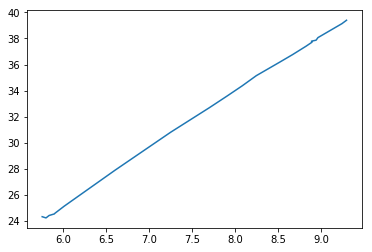

4.349760774048806 -0.9138358767060097 0.9997700993805362 3.555362173314687e-33 0.02140171291399685


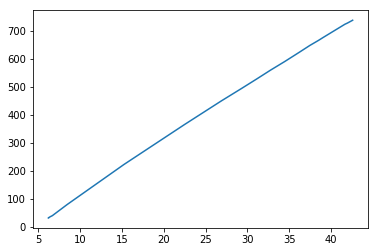

19.61044351659781 -86.3003498716406 0.9997843381757402 1.936967760191278e-33 0.0934506884034608


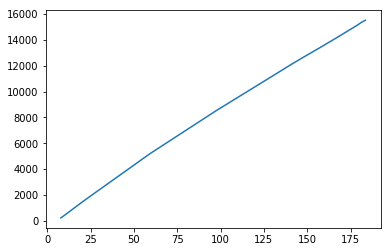

87.60947030332412 -381.2439259303819 0.9996599284954756 1.465499944660288e-31 0.5243064056226888


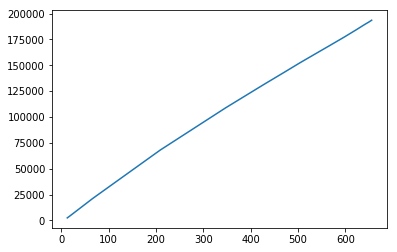

299.2847819078153 -100.59369693703775 0.9995670091074167 1.4536556402128706e-30 2.0211720423329114


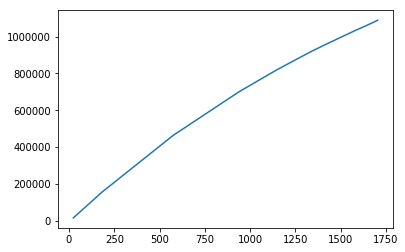

656.9121408771111 15847.782228037308 0.9975116334704109 2.3640960509218027e-23 10.651587831644548


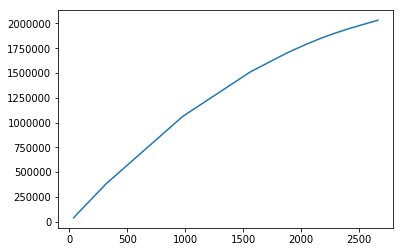

805.5737807307703 49472.546260567615 0.9938359172830638 1.288485705938594e-19 20.615447697016993


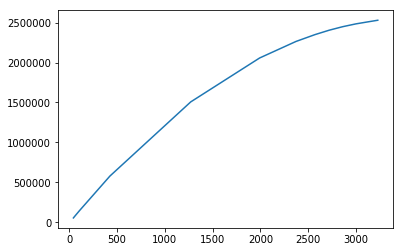

843.4409043272341 72844.57552208297 0.9911303415896185 4.0449409333828435e-18 25.944803134424472


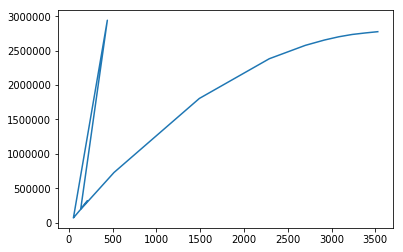

800.7385072559247 273617.5268889364 0.8938562289970163 4.8007407011932936e-08 92.14398753973269


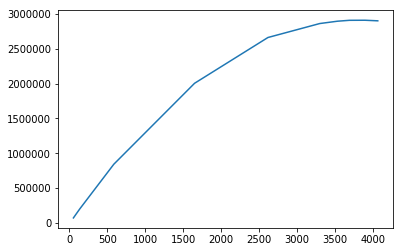

786.6768423572028 102533.49686866056 0.9843269672439935 8.796910239226441e-16 32.33428931078082


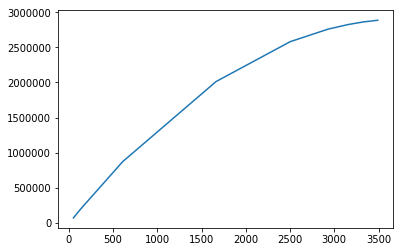

891.5434057798358 71651.17661031592 0.9909570753520603 4.857814266080627e-18 27.694673738296313


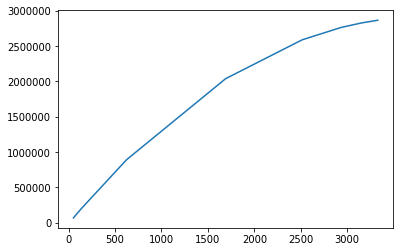

921.9512676225066 61201.18907582667 0.9919385018912037 1.637196475318869e-18 27.0204301792085


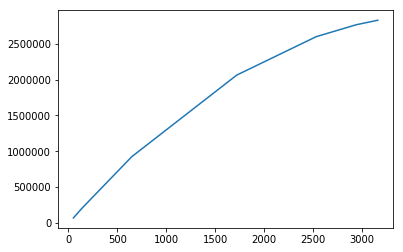

956.557964785953 52079.80824716273 0.992598182868042 7.294082911474804e-19 26.849738267847762


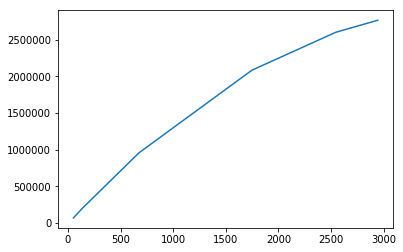

1002.5077152914513 42593.73128663725 0.9933449437117812 2.6634747874173145e-19 26.667231656782285


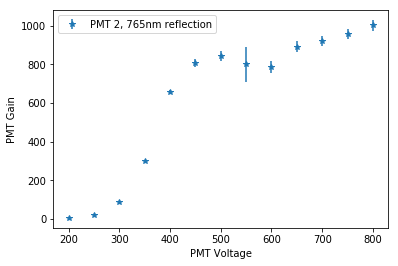

In [22]:
# set modalities of the 2d-parameter-space scan
# do this manually!!

Xmins = [0]
Xsteps = [100]

# PV that corresponds to 50mw OnSample
# maybe not
Xmaxs = [2000]


Vmins = [200]
Vsteps = [50]

# Voltage that slightly oversaturates the uniformly lit sample
Vmaxs = [800]

# construct linspaces
c = len(Xmins)

Xspaces = []
for i in range(c):
    Xspace = np.arange(Xmins[i],Xmaxs[i]+Xsteps[i],Xsteps[i])
    print(Xspace)
    Xspaces.append(Xspace)

Vspaces = []
for i in range(c):
    Vspace = np.arange(Vmins[i],Vmaxs[i]+Vsteps[i],Vsteps[i])
    Vspaces.append(Vspace)

print(Xspaces)
print(Vspaces)

gains = []
offsets = []
std_errs = []

for i in range(c):
    Vlen = len(Vspaces[i])
    for j in range(Vlen):
        Xlen = len(Xspaces[i])
        means = np.zeros(Xlen)
        variances = np.zeros(Xlen)
        for k in range(Xlen):
            (means[k],variances[k]) = value_dict[str(Xspaces[i][k]),str(Vspaces[i][j])]
        slope, intercept, r_value, p_value, std_err = stats.linregress(means, variances)
        plt.plot(means,variances)
        plt.show()
        print(slope, intercept, r_value, p_value, std_err)
        gains.append(slope)
        offsets.append(intercept)
        std_errs.append(std_err)

plt.errorbar(np.asarray(Vspaces).flatten(),gains,yerr=std_errs,
             label='PMT 2, 765nm reflection',linestyle='None',marker='*')
plt.legend()
plt.xlabel('PMT Voltage')
plt.ylabel('PMT Gain')
#plt.xlim(200,0)
#plt.ylim(0,500)
plt.show()

        

[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000]
[array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000])]
[array([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800])]
13
0
1
2
3
4
5
6
7
8
9
10
11
12
(13,)
(21,)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

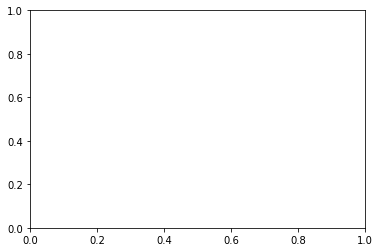

In [20]:
# set modalities of the 2d-parameter-space scan
# do this manually!!

Xmins = [0]
Xsteps = [100]

# PV that corresponds to 50mw OnSample
# maybe not
Xmaxs = [2000]


Vmins = [200]
Vsteps = [50]

# Voltage that slightly oversaturates the uniformly lit sample
Vmaxs = [800]

# construct linspaces
c = len(Xmins)

Xspaces = []
for i in range(c):
    Xspace = np.arange(Xmins[i],Xmaxs[i]+Xsteps[i],Xsteps[i])
    print(Xspace)
    Xspaces.append(Xspace)

Vspaces = []
for i in range(c):
    Vspace = np.arange(Vmins[i],Vmaxs[i]+Vsteps[i],Vsteps[i])
    Vspaces.append(Vspace)

Vspace = np.arange()
    
print(Xspaces)
print(Vspaces)
n = len(np.asarray(Vspaces).flatten())
print(n)
means = np.zeros(len(np.asarray(Vspaces).flatten()))
variances = np.zeros(len(np.asarray(Vspaces).flatten()))

for i in range(c):
    Vlen = len(Vspaces[i])
    for j in range(Vlen):
        print(j)
        Xlen = len(Xspaces[i])
        means = np.zeros(Xlen)
        variances = np.zeros(Xlen)
        #for k in range(Xlen):
        (means[j],variances[j]) = value_dict[str(Xspaces[i][0]),str(Vspaces[i][j])]
        #slope, intercept, r_value, p_value, std_err = stats.linregress(mean, variance)

        
print(np.asarray(Vspaces).flatten().shape)
print(means.shape)
plt.errorbar(np.asarray(Vspaces).flatten(),means,yerr=variances,
             label='PMT 2 Trititum',linestyle='None',marker='*')
plt.legend()
plt.xlabel('PMT Voltage')
plt.ylabel('Signal')
#plt.xlim(200,0)
#plt.ylim(0,500)
plt.show()